# Validate the data
(test generated data extracted from the video)

Landmark Tensor Shape: (21873, 68, 2)
Frame Distance From Ref Array Length: (21873,)


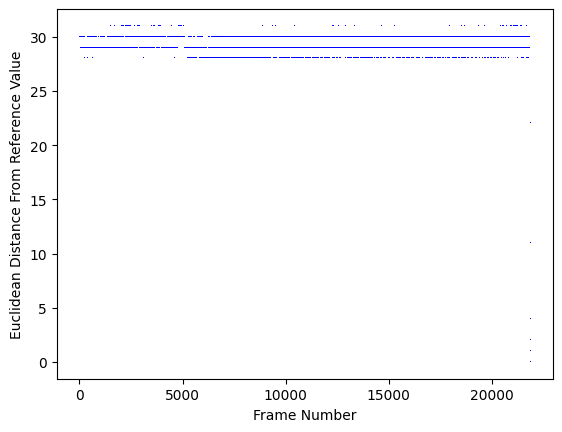

In [8]:
import numpy as np
import matplotlib.pyplot as plt

Name = "AviC"

landmark_tensor = np.load(f"data/{Name}_landmark.npy")
print(f"Landmark Tensor Shape: {landmark_tensor.shape}")

distances = np.load(f"data/{Name}_distance.npy")
print(f"Frame Distance From Ref Array Length: {distances.shape}")

x = range(distances.shape[0])
plt.plot(x, distances, ',b')
# plt.title("Cropped Frame Average Pixel Distance From Reference Frame")
plt.xlabel("Frame Number")
plt.ylabel("Euclidean Distance From Reference Value")
plt.show()


## Transform the distances data to the binary self-report signal

Middle Distance Value = 14.0
Number Of Self-Reports: 1


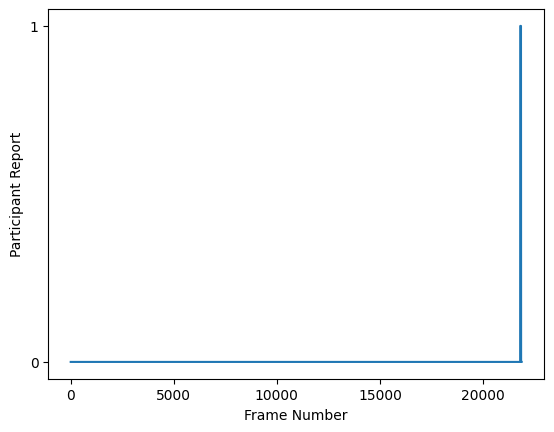

In [9]:
middle_distance = (np.mean(distances) // 2) # Find the optimal solution
print(f"Middle Distance Value = {middle_distance}")

roundBinary = np.vectorize(lambda t: 1 if (t < middle_distance) else 0)
binary_report = roundBinary(distances)
binary_report = np.concatenate((np.split(binary_report, [30])[1], np.zeros(30)))

# Find the number of reports (210 frames per report)
def countRep(arr):
    i = 0
    count = 0
    while i < len(arr):
        if arr[i] == 1:
            i += 240 # skip 8 seconds 
            count += 1
        else:
            i += 1
    return count

c = countRep(binary_report)
print(f"Number Of Self-Reports: {c}")

# Plot binary report
plt.plot(x, binary_report)
# plt.title("Participant Self Report")
plt.xlabel("Frame Number")
plt.ylabel("Participant Report")

plt.yticks([0, 1])

plt.show()

## Transfrom the 68 landmark points to the face features
(Need to include the features module)